In [1]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error
from kmodes.kprototypes import KPrototypes

from time import time

pd.set_option("display.max_columns", None)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import du dataset et vérification de la donnée

In [2]:
df = pd.read_csv("QueryResults.csv", sep=',')

In [3]:
df

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How do I set permissions (attributes) on a fil...,<p>When I extract files from a ZIP file create...,<python><attributes><zip><file-permissions><zi...,434641,46,29340,7,8
1,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,65,136478,21,9
2,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56219,12,8
3,flutter: no refresh indicator when using Refre...,"<p>I added the RefreshIndicator to my page, bu...",<flutter><dart><refresh><pull-to-refresh><indi...,54051121,33,46515,7,5
4,Angularjs Form/Field validation using JavaScri...,<p>Is there a way to validate a field in angul...,<javascript><validation><angularjs><angular-ui...,18125777,10,30234,7,4
...,...,...,...,...,...,...,...,...
46032,How do I fix the npm UNMET PEER DEPENDENCY war...,"<p>I'm on Windows 10, with Node 5.6.0 and npm ...",<angularjs><node.js><npm><npm-install><angular...,35738346,283,338197,48,13
46033,"Why does Math.min() return -0 from [+0, 0, -0]",<p>I know (-0 === 0) comes out to be true. I a...,<javascript><math><floating-point><min><negati...,70450352,59,3803,7,4
46034,What's the mathematical reason behind Python c...,<p>I know Python <code>//</code> rounds toward...,<python><c++><python-3.x><rounding><integer-di...,70730831,85,7540,9,8
46035,Unable to load class AndroidComponentsExtensio...,"<p>I recently downloaded <a href=""https://deve...",<android><android-gradle-plugin><android-archi...,70857476,123,12650,7,7


<AxesSubplot:>

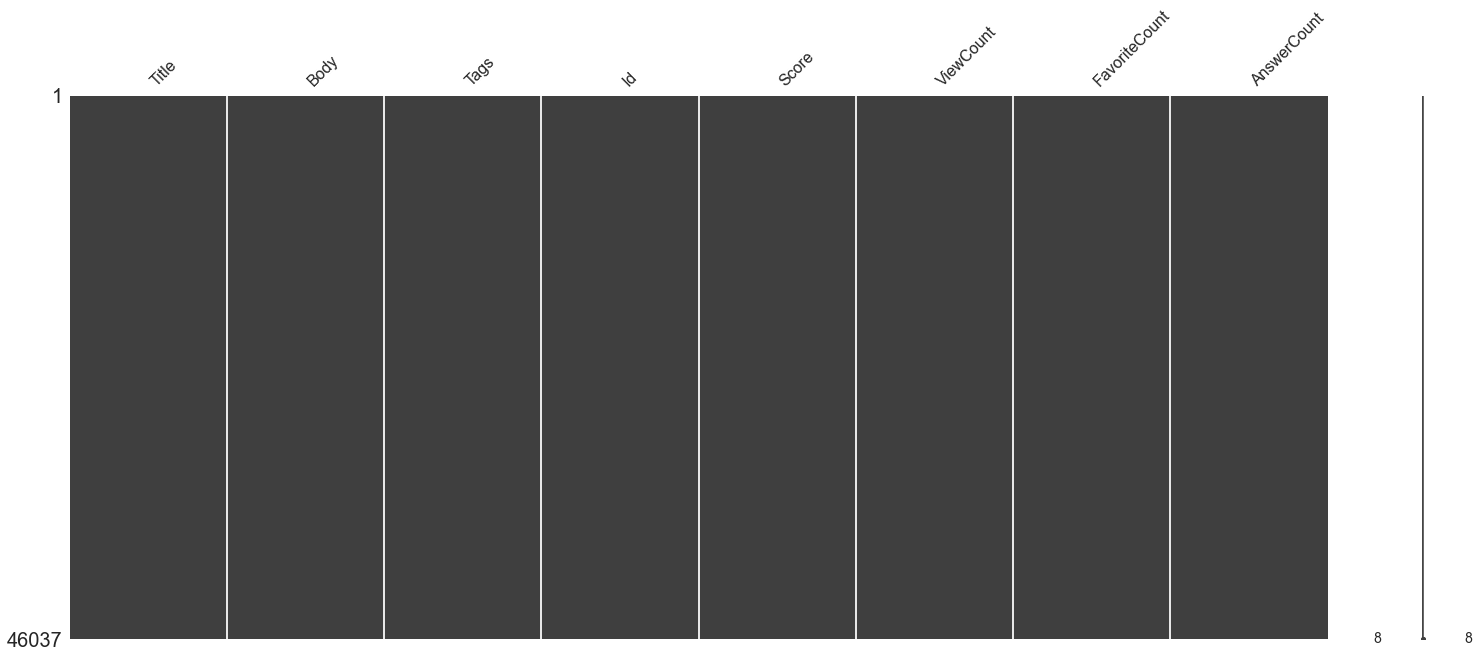

In [4]:
msno.matrix(df)

In [5]:
df["Score"].describe()

count    46037.000000
mean        76.709147
std        280.577925
min          6.000000
25%         18.000000
50%         32.000000
75%         64.000000
max      26330.000000
Name: Score, dtype: float64

In [6]:
df["ViewCount"].describe()

count    4.603700e+04
mean     7.557115e+04
std      1.901661e+05
min      1.410000e+02
25%      1.282100e+04
50%      2.997900e+04
75%      7.161100e+04
max      9.825125e+06
Name: ViewCount, dtype: float64

In [7]:
df["FavoriteCount"].describe()

count    46037.000000
mean        28.802854
std        117.761812
min          7.000000
25%          8.000000
50%         12.000000
75%         22.000000
max      11563.000000
Name: FavoriteCount, dtype: float64

In [8]:
df["AnswerCount"].describe()

count    46037.000000
mean         5.824945
std          5.713050
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        125.000000
Name: AnswerCount, dtype: float64

## Analyse Univariée

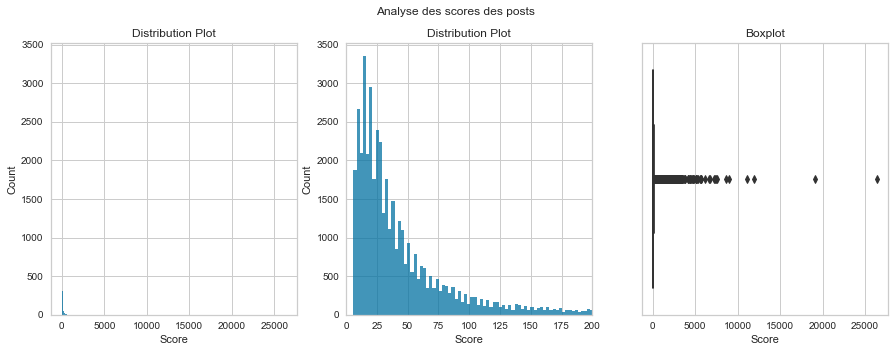

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Analyse des scores des posts")

sns.histplot(ax=axes[0], x="Score", data=df)
axes[0].set_title("Distribution Plot")

sns.histplot(ax=axes[1], x="Score", data=df)
axes[1].set_title("Distribution Plot")
axes[1].set_xlim([0,200])

sns.boxplot(ax=axes[2], x="Score", data=df)
axes[2].set_title("Boxplot")

plt.show()

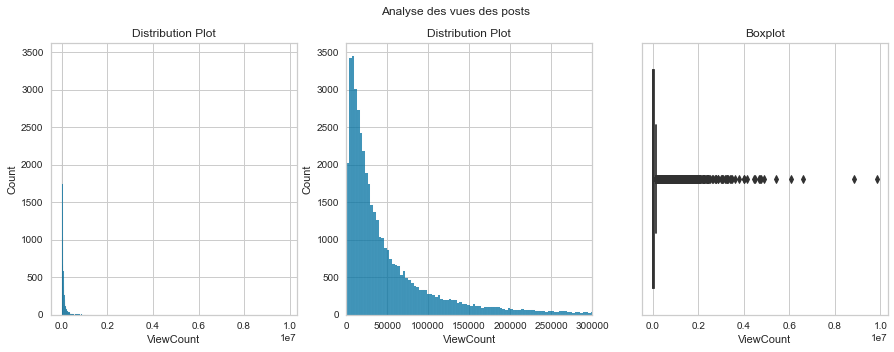

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Analyse des vues des posts")

sns.histplot(ax=axes[0], x="ViewCount", data=df)
axes[0].set_title("Distribution Plot")

sns.histplot(ax=axes[1], x="ViewCount", data=df)
axes[1].set_title("Distribution Plot")
axes[1].set_xlim([0,300000])

sns.boxplot(ax=axes[2], x="ViewCount", data=df)
axes[2].set_title("Boxplot")

plt.show()

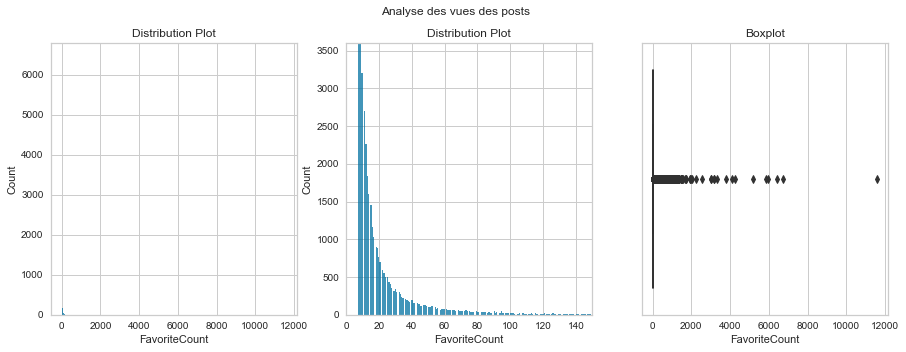

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Analyse des vues des posts")

sns.histplot(ax=axes[0], x="FavoriteCount", data=df)
axes[0].set_title("Distribution Plot")

sns.histplot(ax=axes[1], x="FavoriteCount", data=df)
axes[1].set_title("Distribution Plot")
axes[1].set_xlim([0,150])
axes[1].set_ylim([0,3600])

sns.boxplot(ax=axes[2], x="FavoriteCount", data=df)
axes[2].set_title("Boxplot")

plt.show()

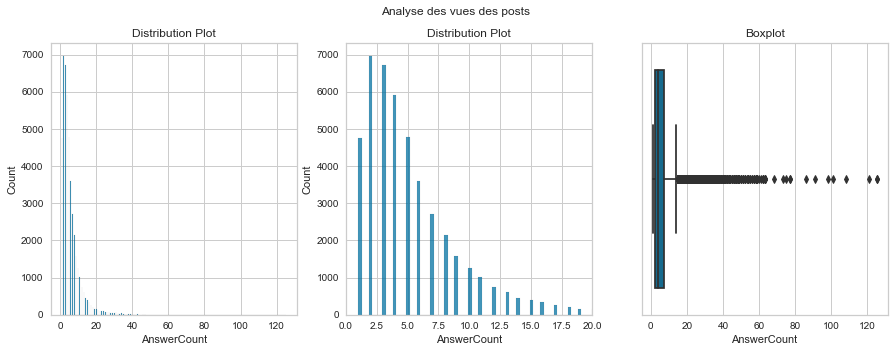

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Analyse des vues des posts")

sns.histplot(ax=axes[0], x="AnswerCount", data=df)
axes[0].set_title("Distribution Plot")

sns.histplot(ax=axes[1], x="AnswerCount", data=df)
axes[1].set_title("Distribution Plot")
axes[1].set_xlim([0,20])

sns.boxplot(ax=axes[2], x="AnswerCount", data=df)
axes[2].set_title("Boxplot")

plt.show()

## Analyse bivariée

<AxesSubplot:>

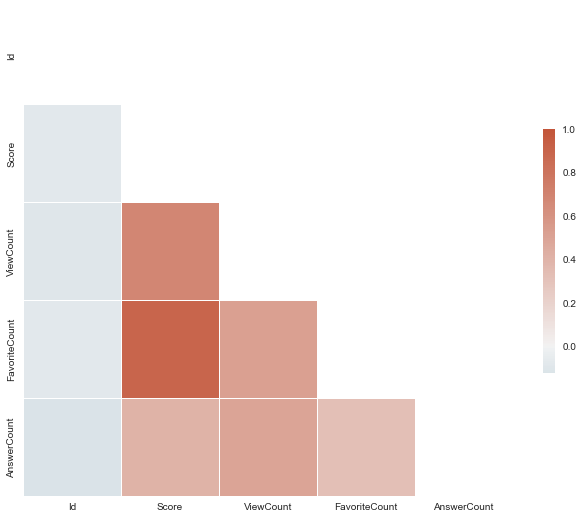

In [15]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

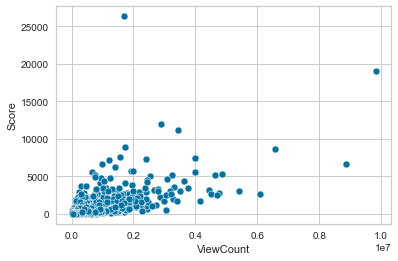

In [20]:
sns.scatterplot(data=df, x="ViewCount", y="Score")
plt.show()

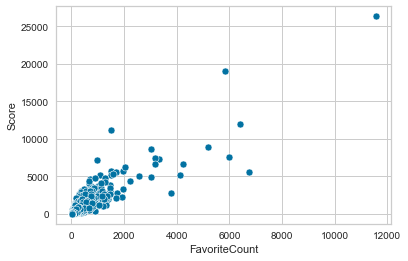

In [21]:
sns.scatterplot(data=df, x="FavoriteCount", y="Score")
plt.show()

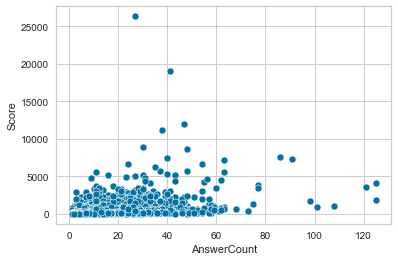

In [22]:
sns.scatterplot(data=df, x="AnswerCount", y="Score")
plt.show()

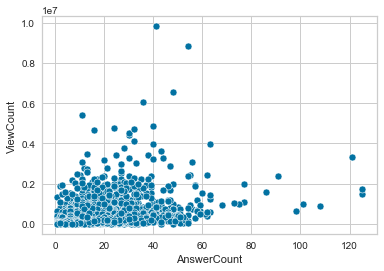

In [23]:
sns.scatterplot(data=df, x="AnswerCount", y="ViewCount")
plt.show()

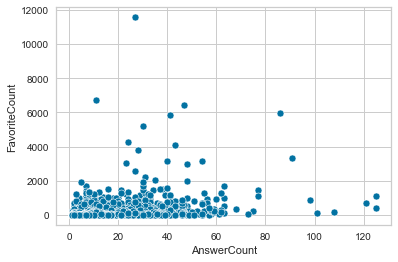

In [24]:
sns.scatterplot(data=df, x="AnswerCount", y="FavoriteCount")
plt.show()

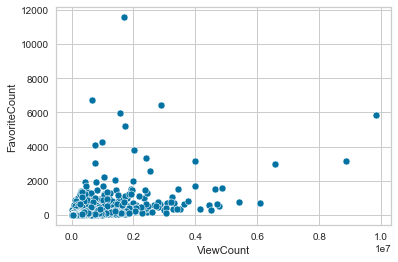

In [25]:
sns.scatterplot(data=df, x="ViewCount", y="FavoriteCount")
plt.show()